# Black-Litterman allocation

The Black-Litterman method is a very powerful way of converting your views on asset returns, along with your uncertainty in these views, into a portfolio.

For a description of the theory, please read the [documentation page](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and the links therein.

In this recipe, we will cover:

- Downloading data for the Black-Litterman method
- Constructing the prior return vector based on market equilibrium
- Two ways of constructing the uncertainty matrix
- Combining Black-Litterman with mean-variance optimization

## Downloading data

In addition to price data, constructing a market prior requires market-caps.


In [1]:
! pip install pandas numpy matplotlib yfinance PyPortfolioOpt
# import os
# if not os.path.isdir('data'):
#     os.system('git clone https://github.com/robertmartin8/PyPortfolioOpt.git')
#     os.chdir('PyPortfolioOpt/cookbook')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST", "SBUX"]

In [4]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%%**********************]  10 of 10 completed


,AMZN,BAC,COST,DIS,DPZ,KO,MCD,MSFT,NAT,SBUX
Date,,,,,,,,,,
2023-12-19,153.789993,33.509998,677.739990,93.930000,406.549988,58.830002,290.730011,373.260010,4.30,97.720001
2023-12-20,152.119995,32.980000,661.000000,91.269997,403.250000,57.610001,288.989990,370.619995,4.31,94.709999
2023-12-21,153.839996,33.200001,665.159973,92.019997,408.799988,57.990002,291.390015,373.540009,4.36,95.330002
2023-12-22,153.419998,33.430000,671.599976,91.019997,409.839996,58.320000,291.700012,374.579987,4.54,95.279999
2023-12-26,153.410004,33.860001,674.619995,90.949997,411.339996,58.560001,292.859985,374.660004,4.36,95.669998


In [5]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


Date
1993-01-29    24.840687
1993-02-01    25.017351
1993-02-02    25.070364
1993-02-03    25.335379
1993-02-04    25.441387
Name: Adj Close, dtype: float64

In [6]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MSFT': 2784570638336,
 'AMZN': 1585339039744,
 'NAT': 910350592,
 'BAC': 267958910976,
 'DPZ': 14347950080,
 'DIS': 166467600384,
 'KO': 253178888192,
 'MCD': 212423655424,
 'COST': 299347771392,
 'SBUX': 108748087296}

## Constructing the prior

In [8]:
import pypfopt
pypfopt.__version__

'1.5.5'

In [9]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.645919196103754

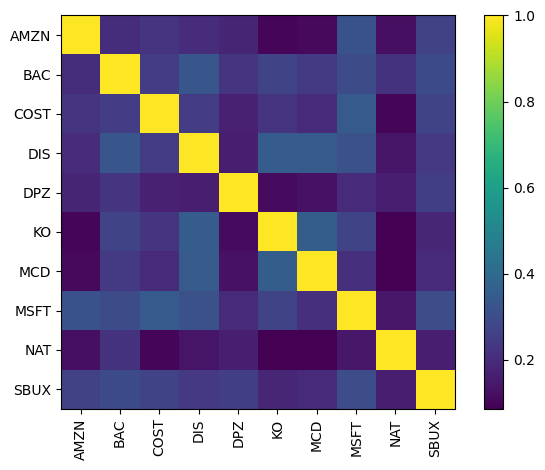

In [10]:
plotting.plot_covariance(S, plot_correlation=True);

In [11]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AMZN    0.172972
BAC     0.100880
COST    0.080148
DIS     0.092621
DPZ     0.049561
KO      0.063157
MCD     0.067228
MSFT    0.145606
NAT     0.052229
SBUX    0.080859
dtype: float64

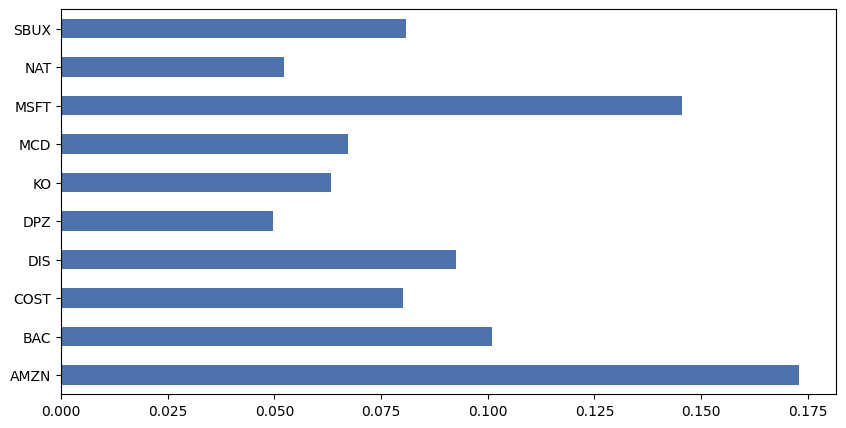

In [12]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [13]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [14]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

In [15]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

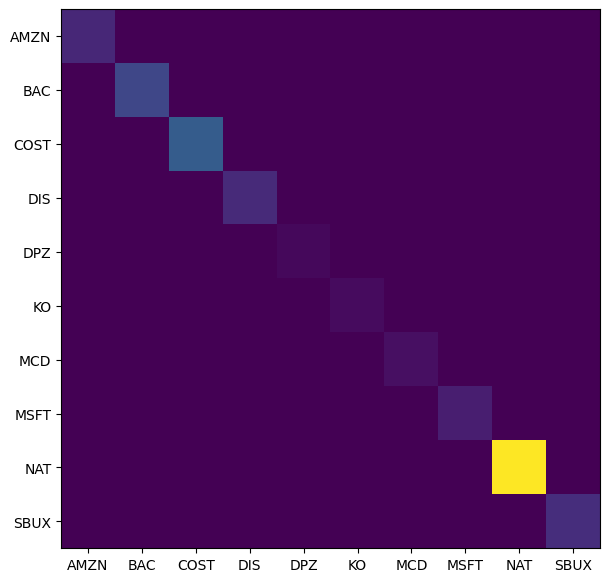

In [16]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [17]:
np.diag(bl.omega)

array([0.00459815, 0.00885007, 0.0120955 , 0.00496576, 0.00086098,
       0.00113928, 0.00169892, 0.00346853, 0.0413603 , 0.00540064])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [18]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [19]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [20]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [21]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AMZN    0.148646
BAC     0.129893
COST    0.062752
DIS     0.070663
DPZ     0.104680
KO      0.007376
MCD     0.102948
MSFT    0.104484
NAT     0.061376
SBUX    0.082140
dtype: float64

We can visualise how this compares to the prior and our views:

In [22]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMZN,0.172972,0.148646,0.10
BAC,0.100880,0.129893,0.30
COST,0.080148,0.062752,0.05
DIS,0.092621,0.070663,0.05
DPZ,0.049561,0.104680,0.20
KO,0.063157,0.007376,-0.05
MCD,0.067228,0.102948,0.15
MSFT,0.145606,0.104484,0.10
NAT,0.052229,0.061376,0.50
SBUX,0.080859,0.082140,0.10


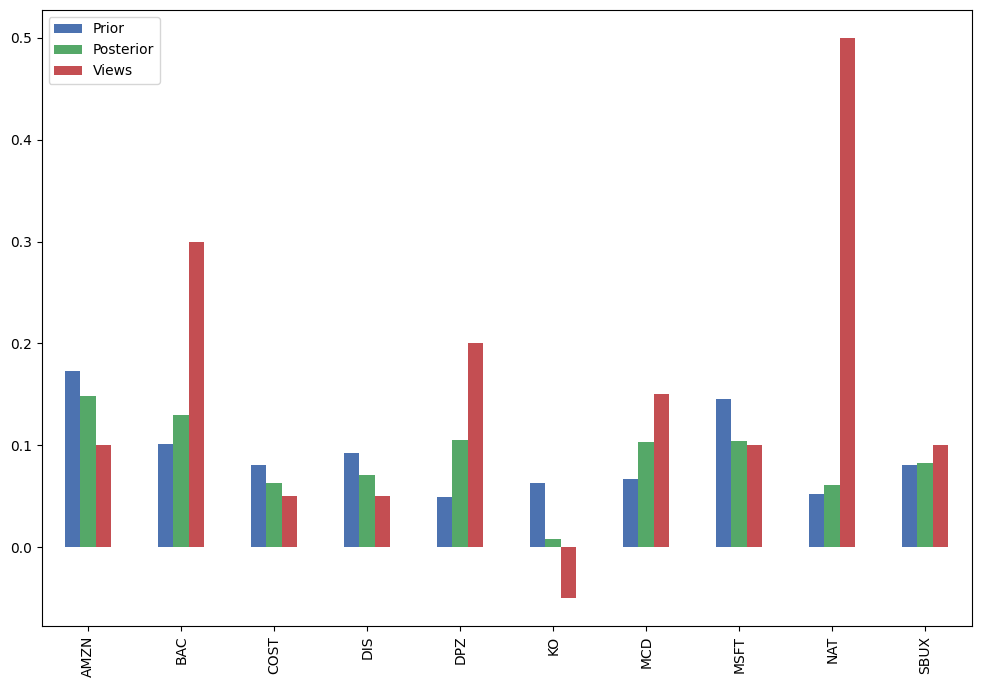

In [23]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

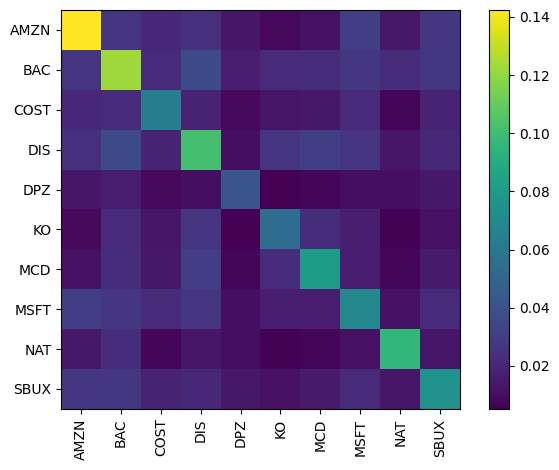

In [24]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [25]:
from pypfopt import EfficientFrontier, objective_functions

In [26]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/home/skymeta/anaconda3/envs/finlab/lib/python3.8/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AMZN', 0.18861),
             ('BAC', 0.15864),
             ('COST', 0.05745),
             ('DIS', 0.06281),
             ('DPZ', 0.13722),
             ('KO', 0.0),
             ('MCD', 0.12648),
             ('MSFT', 0.12508),
             ('NAT', 0.05679),
             ('SBUX', 0.08693)])

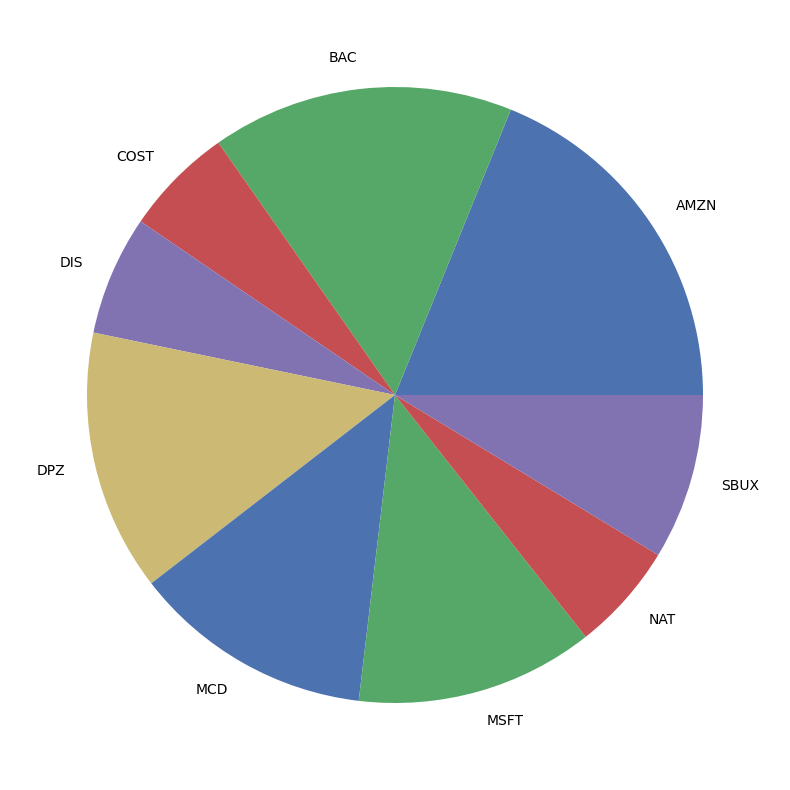

In [27]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [28]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $754.02


/home/skymeta/anaconda3/envs/finlab/lib/python3.8/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'BAC': 105,
 'COST': 2,
 'DIS': 17,
 'DPZ': 7,
 'KO': 8,
 'MCD': 9,
 'MSFT': 7,
 'NAT': 500,
 'SBUX': 21}